Group Project: Predicting Employee Attrition

Dataset: 

[IBM HR Analytics Employee Attrition & Performance
](https://www.kaggle.com/datasets/pavansubha)

Group members: 

Sarah Nazurah binti Zulhairy (1810324)

Nur Qhaisara binti Mohd Zakzam (1913074)

Khaleeda Zahra binti Zulkifli (1913334)

Nur Syafiqah binti Zakaria (1914770)

# **Setting Preliminaries & Environment**

In [80]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
# Set Environment Variables
# Set the locations where Spark and Java are installed.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [82]:
# Import library needed
import findspark
findspark.init()

import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import mean
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col,regexp_replace
from pyspark.sql.functions import isnan, when, count, col

In [83]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Property used to format output tables better
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [84]:
spark = SparkSession\
        .builder\
        .appName("employeeAttrition")\
        .getOrCreate()

In [85]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '37459'),
 ('spark.driver.host', '53875e9037c9'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1657544940665'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.startTime', '1657544939256')]

# **Dataset's Path**

In [86]:
# Create data folder in google colab
path = "data/WA_Fn-UseC_-HR-Employee-Attrition.csv" 

# InferSchema decides vartype
attrition_Emp_df = spark.read.csv(path, header = True, inferSchema = True) 

# **Data Preprocessing and Data Cleaning**

In [87]:
# Check the DataTypes of the Columns
attrition_Emp_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

In [88]:
# Check any null values
attrition_Emp_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in attrition_Emp_df.columns]).show() 

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPr

In [89]:
# Check how many rows in dataset we have 
attrition_Emp_df.count()

1470

In [90]:
# Remove any duplication in the dataset. if any 
attrition_Emp_df.dropDuplicates()

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
27,No,Travel_Rarely,608,Research & Develo...,1,2,Life Sciences,1,725,3,Female,68,3,3,Manufacturing Dir...,1,Married,7412,6009,1,Y,No,11,3,4,80,0,9,3,3,9,7,0,7
41,No,Travel_Rarely,314,Human Resources,1,3,Human Resources,1,734,4,Male,59,2,5,Manager,3,Married,19189,19562,1,Y,No,12,3,2,80,1,22,3,3,22,7,2,10
25,No,Travel_Rarely,141,Sales,3,1,Other,1,879,3,Male,98,3,2,Sales Executive,1,Married,4194,14363,1,Y,Yes,18,3,4,80,0,5,3,3,5,3,0,3
21,Yes,Travel_Rarely,1427,Research & Develo...,18,1,Other,1,923,4,Female,65,3,1,Research Scientist,4,Single,2693,8870,1,Y,No,19,3,1,80,0,1,3,2,1,0,0,0
56,No,Travel_Rarely,718,Research & Develo...,4,4,Technical Degree,1,1191,4,Female,92,3,5,Manager,1,Divorced,19943,18575,4,Y,No,13,3,4,80,1,28,2,3,5,2,4,2
25,No,Travel_Rarely,949,Research & Develo...,1,3,Technical Degree,1,1415,1,Male,81,3,1,Laboratory Techni...,4,Married,3229,4910,4,Y,No,11,3,2,80,1,7,2,2,3,2,0,2
27,No,Travel_Rarely,591,Research & Develo...,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Techni...,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
34,No,Non-Travel,1065,Sales,23,4,Marketing,1,60,2,Male,72,3,2,Sales Executive,3,Single,4568,10034,0,Y,No,20,4,3,80,0,10,2,3,9,5,8,7
50,No,Travel_Rarely,328,Research & Develo...,1,3,Medical,1,249,3,Male,86,2,1,Laboratory Techni...,3,Married,3690,3425,2,Y,No,15,3,4,80,1,5,2,2,3,2,0,2
25,No,Non-Travel,675,Research & Develo...,5,2,Life Sciences,1,369,2,Male,85,4,2,Healthcare Repres...,1,Divorced,4000,18384,1,Y,No,12,3,4,80,2,6,2,3,6,3,1,5


In [91]:
# To check whether there is a any rows being drop for duplicate values
attrition_Emp_df.count()

1470

# **Data Transformation**

In [92]:
# Drop column that does not use for the analysis
drop_columns = ("BusinessTravel", "DailyRate", "DistanceFromHome", "EmployeeCount", "JobLevel", "MaritalStatus", "MonthlyRate", "NumCompaniesWorked", "Over18", "PercentSalaryHike", "RelationshipSatisfaction", "StandardHours", "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager")  
updated_attrition_Emp_df = attrition_Emp_df.drop(*drop_columns) 

In [93]:
updated_attrition_Emp_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)



In [94]:
updated_attrition_Emp_df.show()

+---+---------+--------------------+---------+--------------+--------------+-----------------------+------+----------+--------------+--------------------+---------------+-------------+--------+-----------------+----------------+-----------------+---------------+
|Age|Attrition|          Department|Education|EducationField|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|             JobRole|JobSatisfaction|MonthlyIncome|OverTime|PerformanceRating|StockOptionLevel|TotalWorkingYears|WorkLifeBalance|
+---+---------+--------------------+---------+--------------+--------------+-----------------------+------+----------+--------------+--------------------+---------------+-------------+--------+-----------------+----------------+-----------------+---------------+
| 41|      Yes|               Sales|        2| Life Sciences|             1|                      2|Female|        94|             3|     Sales Executive|              4|         5993|     Yes|                3|

**Data wrangling for Attrition and OverTime attributes**

In [95]:
updated_attrition_Emp_df = updated_attrition_Emp_df.withColumn("Attrition", F.when(updated_attrition_Emp_df.Attrition == "Yes", 1).otherwise(0)).withColumn("OverTime", F.when(updated_attrition_Emp_df.OverTime == "Yes", 1).otherwise(0))

In [96]:
updated_attrition_Emp_df.show(truncate=False)

+---+---------+----------------------+---------+--------------+--------------+-----------------------+------+----------+--------------+-------------------------+---------------+-------------+--------+-----------------+----------------+-----------------+---------------+
|Age|Attrition|Department            |Education|EducationField|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobRole                  |JobSatisfaction|MonthlyIncome|OverTime|PerformanceRating|StockOptionLevel|TotalWorkingYears|WorkLifeBalance|
+---+---------+----------------------+---------+--------------+--------------+-----------------------+------+----------+--------------+-------------------------+---------------+-------------+--------+-----------------+----------------+-----------------+---------------+
|41 |1        |Sales                 |2        |Life Sciences |1             |2                      |Female|94        |3             |Sales Executive          |4              |5993         

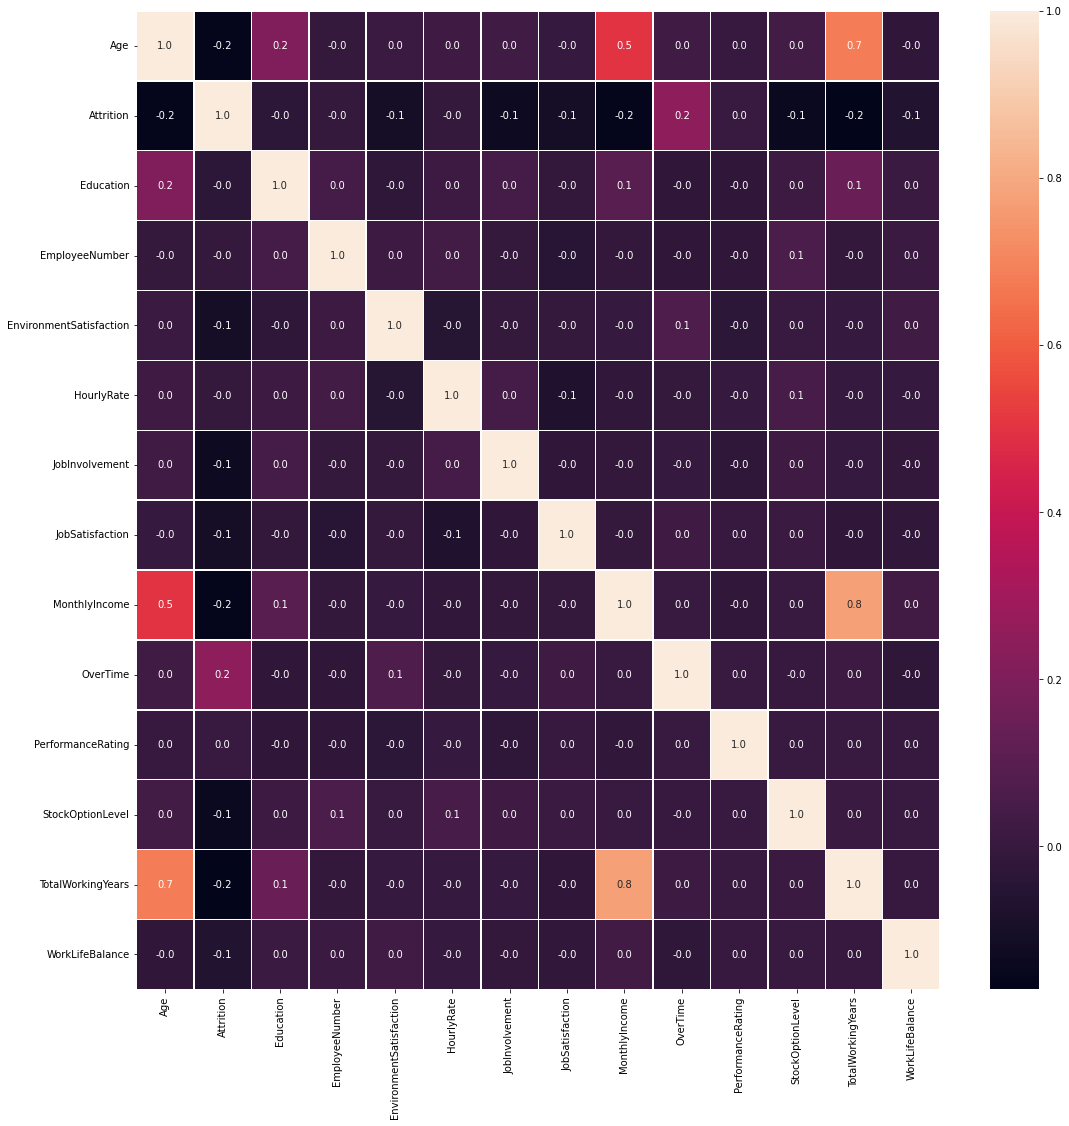

In [97]:
updated_attrition_Emp_df_pd = updated_attrition_Emp_df.toPandas()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(updated_attrition_Emp_df_pd.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [98]:
features = ["Age", "Education", "EmployeeNumber", "EnvironmentSatisfaction", "HourlyRate", "JobInvolvement", "JobSatisfaction", "MonthlyIncome", "OverTime", "PerformanceRating", "StockOptionLevel", "TotalWorkingYears", "WorkLifeBalance"]

# **Exploratory Data Analysis**

##**Predictive Analysis Questions**


### **Data Science Question 1**

In [99]:
jobinv_edu = updated_attrition_Emp_df.select(col("EducationField"),("JobInvolvement"))
jobinv_edu = updated_attrition_Emp_df.filter((updated_attrition_Emp_df.JobInvolvement == "3"))

In [100]:
jobinv_edu = jobinv_edu.toPandas()

In [101]:
jobinv_edu

,Age,Attrition,Department,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MonthlyIncome,OverTime,PerformanceRating,StockOptionLevel,TotalWorkingYears,WorkLifeBalance
0,41,1,Sales,2,Life Sciences,1,2,Female,94,3,Sales Executive,4,5993,1,3,0,8,1
1,33,0,Research & Development,4,Life Sciences,5,4,Female,56,3,Research Scientist,3,2909,1,3,0,8,3
2,27,0,Research & Development,1,Medical,7,1,Male,40,3,Laboratory Technician,2,3468,0,3,1,6,3
3,32,0,Research & Development,2,Life Sciences,8,4,Male,79,3,Laboratory Technician,4,3068,0,3,0,8,2
4,30,0,Research & Development,1,Life Sciences,11,4,Male,67,3,Laboratory Technician,3,2693,0,4,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,50,1,Sales,4,Life Sciences,2044,2,Male,94,3,Sales Executive,3,6728,0,3,2,12,3
864,45,0,Sales,3,Life Sciences,2046,4,Female,50,3,Sales Executive,3,4850,0,3,0,8,3
865,35,0,Research & Development,4,Life Sciences,2049,3,Male,80,3,Healthcare Representative,3,5689,1,3,2,10,4
866,40,0,Research & Development,4,Medical,2051,3,Female,98,3,Research Scientist,3,2001,0,3,3,20,3


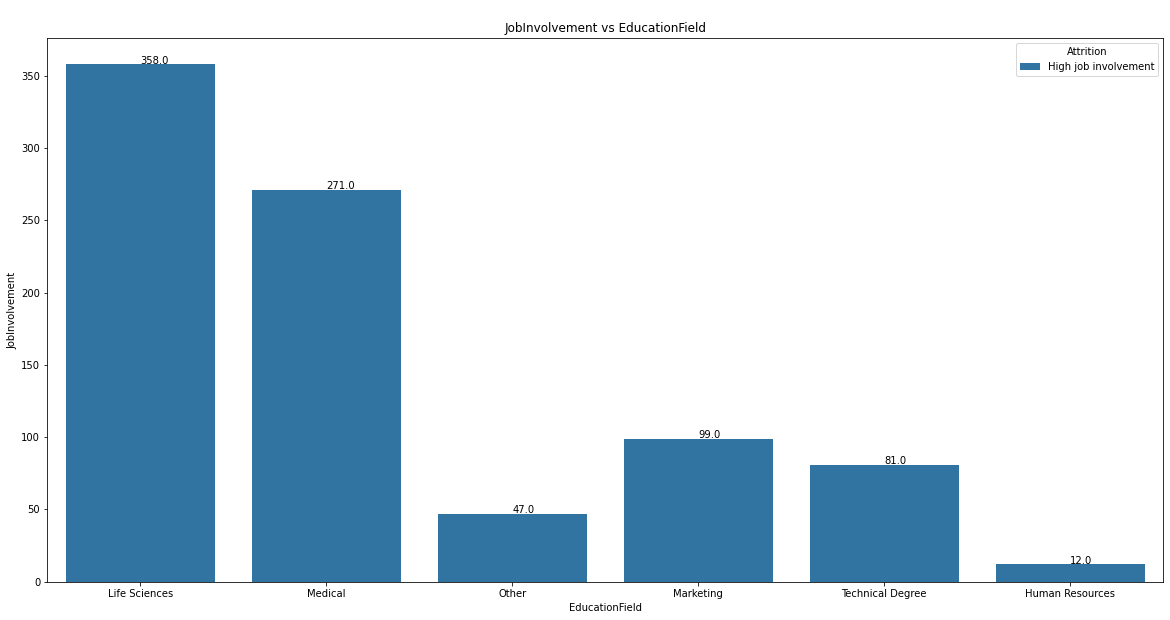

In [102]:
plt.figure(figsize = (20,10))

Graph1 = sns.countplot(x="EducationField", hue = "JobInvolvement", data=jobinv_edu)

for p in Graph1.patches:
   Graph1.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.40, p.get_height()+0.30))

plt.legend(title='Attrition', loc='upper right', labels=['High job involvement'])

Graph1.set(title='\nJobInvolvement vs EducationField')

x_ticks_labels = ['Life Sciences', 'Medical', 'Other', 'Marketing', 'Technical Degree', 'Human Resources']

Graph1.set_xticklabels(x_ticks_labels)
plt.xlabel('EducationField')
plt.ylabel('JobInvolvement')
plt.show()

In [103]:
percent_medical_edu = 271.0/868.0*100.0
percent_medical_edu

31.22119815668203

###**Data Science Question 2**

In [104]:
department_overtime = updated_attrition_Emp_df.select(col("Department"),("OverTime"))
department_overtime = updated_attrition_Emp_df.filter((updated_attrition_Emp_df.OverTime == "1"))

In [105]:
department_overtime = department_overtime.toPandas()

In [106]:
department_overtime

,Age,Attrition,Department,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MonthlyIncome,OverTime,PerformanceRating,StockOptionLevel,TotalWorkingYears,WorkLifeBalance
0,41,1,Sales,2,Life Sciences,1,2,Female,94,3,Sales Executive,4,5993,1,3,0,8,1
1,37,1,Research & Development,2,Other,4,4,Male,92,2,Laboratory Technician,3,2090,1,3,0,7,3
2,33,0,Research & Development,4,Life Sciences,5,4,Female,56,3,Research Scientist,3,2909,1,3,0,8,3
3,59,0,Research & Development,3,Medical,10,3,Female,81,4,Laboratory Technician,1,2670,1,4,3,12,2
4,29,0,Research & Development,2,Life Sciences,15,4,Female,49,2,Laboratory Technician,3,4193,1,3,0,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,35,0,Human Resources,4,Life Sciences,2040,3,Female,31,3,Human Resources,4,8837,1,3,0,9,3
412,35,0,Research & Development,4,Life Sciences,2049,3,Male,80,3,Healthcare Representative,3,5689,1,3,2,10,4
413,29,0,Research & Development,2,Other,2053,4,Male,46,2,Laboratory Technician,2,4025,1,3,1,10,3
414,50,1,Sales,3,Marketing,2055,4,Male,39,2,Sales Executive,1,10854,1,3,1,20,3


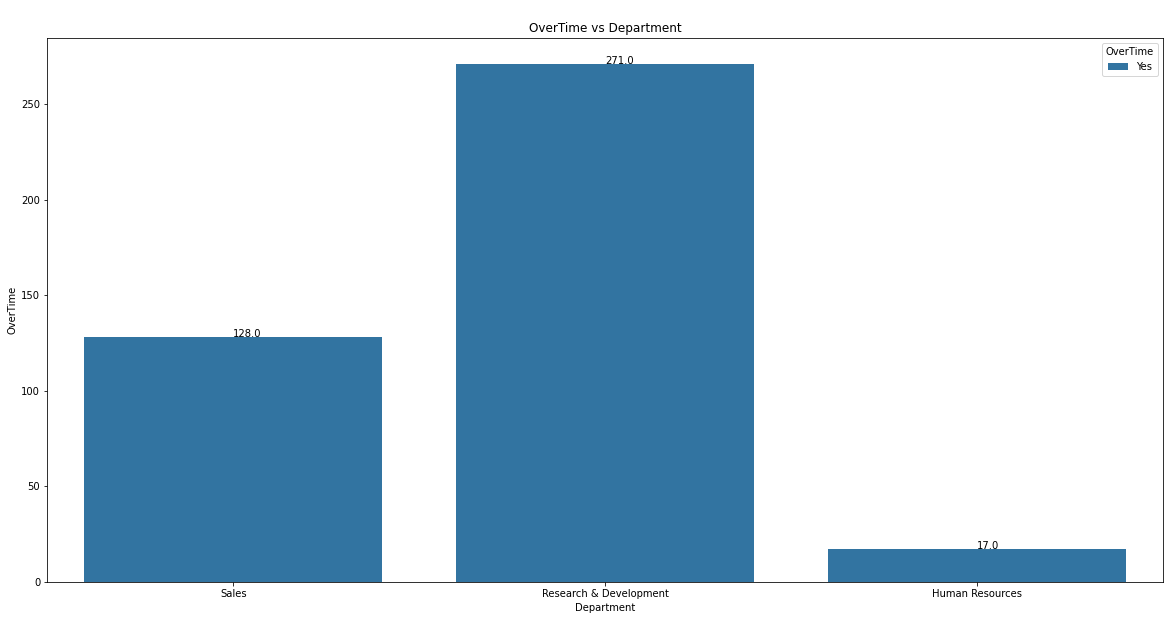

In [107]:
plt.figure(figsize = (20,10))

Graph2 = sns.countplot(x="Department", hue = "OverTime", data=department_overtime)

for p in Graph2.patches:
   Graph2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.40, p.get_height()+0.30))

plt.legend(title='OverTime', loc='upper right', labels=['Yes'])

Graph2.set(title='\nOverTime vs Department')

x_ticks_labels = ['Sales', 'Research & Development', 'Human Resources']

Graph2.set_xticklabels(x_ticks_labels)
plt.xlabel('Department')
plt.ylabel('OverTime')
plt.show()

In [108]:
percent_sales = 128.0/416.0*100.0
percent_sales

30.76923076923077

### **Data Science Question 3**

In [109]:
below_college_high_job_satisfaction = updated_attrition_Emp_df.select(col("Education"),("JobSatisfaction"), ("OverTime"))
below_college_high_job_satisfaction = updated_attrition_Emp_df.filter(updated_attrition_Emp_df.Education == "1")

In [110]:
below_college_high_job_satisfaction = below_college_high_job_satisfaction.toPandas()

In [111]:
below_college_high_job_satisfaction

,Age,Attrition,Department,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MonthlyIncome,OverTime,PerformanceRating,StockOptionLevel,TotalWorkingYears,WorkLifeBalance
0,49,0,Research & Development,1,Life Sciences,2,3,Male,61,2,Research Scientist,2,5130,0,4,1,10,3
1,27,0,Research & Development,1,Medical,7,1,Male,40,3,Laboratory Technician,2,3468,0,3,1,6,3
2,30,0,Research & Development,1,Life Sciences,11,4,Male,67,3,Laboratory Technician,3,2693,0,4,1,1,3
3,31,0,Research & Development,1,Life Sciences,16,1,Male,31,3,Research Scientist,3,2911,0,3,1,5,2
4,34,1,Research & Development,1,Medical,31,2,Male,83,3,Research Scientist,1,2960,0,3,0,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,47,0,Research & Development,1,Medical,2000,3,Female,98,3,Research Director,2,11957,0,3,2,14,1
166,39,0,Research & Development,1,Life Sciences,2014,1,Male,52,3,Research Scientist,4,4108,0,3,0,18,3
167,21,0,Sales,1,Medical,2021,3,Male,58,3,Sales Representative,1,2380,1,3,0,2,3
168,39,0,Sales,1,Marketing,2056,2,Female,60,2,Sales Executive,4,12031,0,3,1,21,2


[Text(0, 0, 'Low'),
 Text(0, 0, 'Medium'),
 Text(0, 0, 'High'),
 Text(0, 0, 'Very High')]

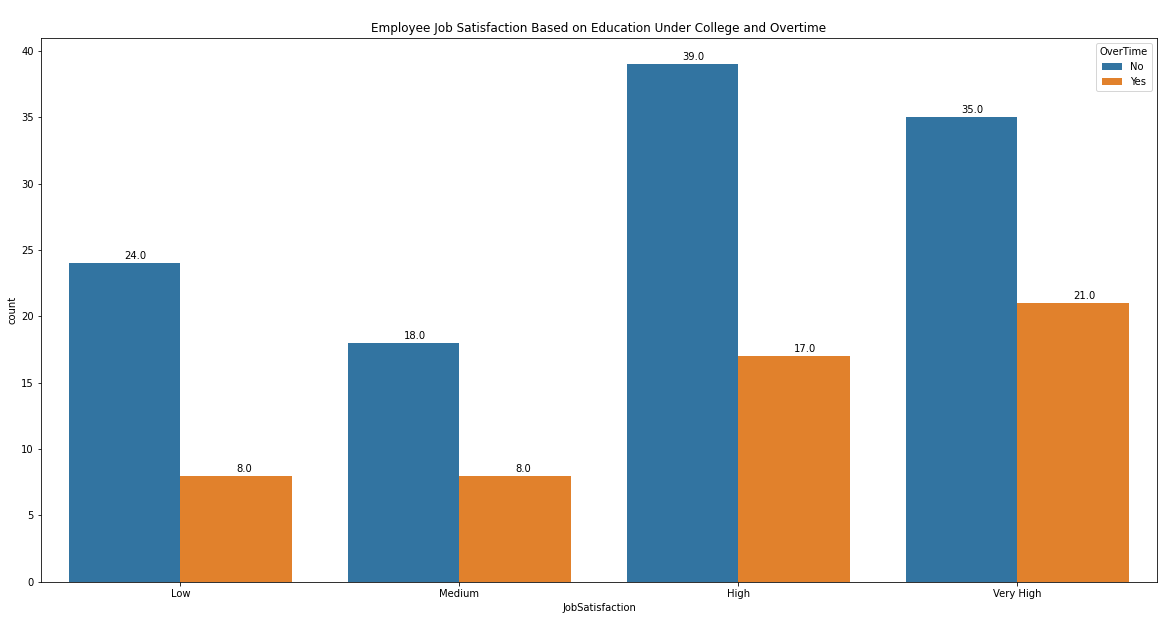

In [112]:
plt.figure(figsize = (20,10))
Graph3 = sns.countplot(x="JobSatisfaction", hue = "OverTime", data=below_college_high_job_satisfaction)

for p in Graph3.patches:
   Graph3.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.20, p.get_height()+0.30))

plt.legend(title='OverTime', loc='upper right', labels=['No', 'Yes'])

Graph3.set(title='\nEmployee Job Satisfaction Based on Education Under College and Overtime')

x_ticks_labels = ['Low', 'Medium', 'High', 'Very High']

Graph3.set_xticklabels(x_ticks_labels)

### **Data Science Question 4**

In [113]:
high_performance_balanced_worklife = updated_attrition_Emp_df.select(col("PerformanceRating"),("WorkLifeBalance"))
high_performance_balanced_worklife = updated_attrition_Emp_df.filter((updated_attrition_Emp_df.PerformanceRating == "4"))

In [114]:
high_performance_balanced_worklife = high_performance_balanced_worklife.toPandas()

In [115]:
high_performance_balanced_worklife

,Age,Attrition,Department,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MonthlyIncome,OverTime,PerformanceRating,StockOptionLevel,TotalWorkingYears,WorkLifeBalance
0,49,0,Research & Development,1,Life Sciences,2,3,Male,61,2,Research Scientist,2,5130,0,4,1,10,3
1,59,0,Research & Development,3,Medical,10,3,Female,81,4,Laboratory Technician,1,2670,1,4,3,12,2
2,30,0,Research & Development,1,Life Sciences,11,4,Male,67,3,Laboratory Technician,3,2693,0,4,1,1,3
3,38,0,Research & Development,3,Life Sciences,12,4,Male,44,2,Manufacturing Director,3,9526,0,4,0,10,3
4,36,1,Sales,4,Life Sciences,27,3,Male,82,2,Sales Representative,1,3407,0,4,0,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,56,0,Research & Development,4,Life Sciences,2026,3,Male,57,3,Healthcare Representative,3,6306,0,4,1,13,2
222,41,0,Research & Development,4,Life Sciences,2034,1,Female,60,2,Manufacturing Director,2,13570,0,4,1,21,3
223,34,0,Sales,3,Marketing,2035,4,Female,95,2,Sales Executive,3,6712,0,4,2,8,3
224,36,0,Sales,4,Marketing,2036,4,Male,88,1,Sales Executive,4,5406,0,4,1,15,2


[Text(0, 0, 'Low'),
 Text(0, 0, 'Medium'),
 Text(0, 0, 'High'),
 Text(0, 0, 'Very High')]

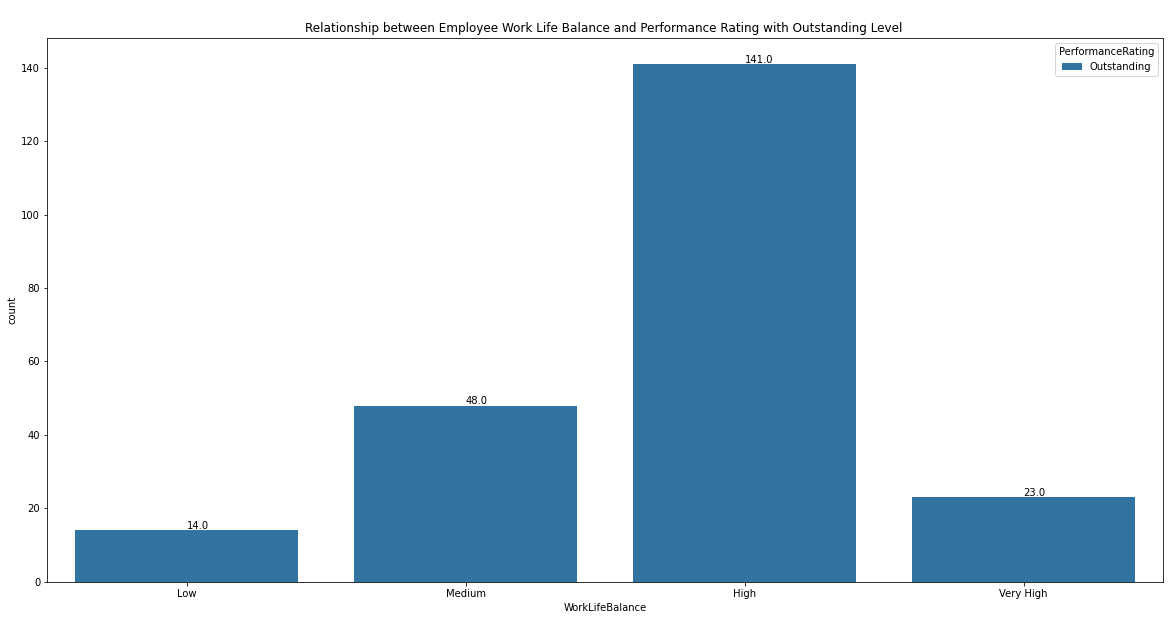

In [116]:
plt.figure(figsize = (20,10))

Graph4 = sns.countplot(x="WorkLifeBalance", hue = "PerformanceRating", data=high_performance_balanced_worklife)

for p in Graph4.patches:
   Graph4.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.40, p.get_height()+0.30))

plt.legend(title='PerformanceRating', loc='upper right', labels=['Outstanding'])

Graph4.set(title='\nRelationship between Employee Work Life Balance and Performance Rating with Outstanding Level ')

Graph4.set_xticklabels(x_ticks_labels)

##**Inferential Analysis Questions**

### **Data Science Question 5**




In [117]:
jobSatisfaction_performanceRate_attrition = updated_attrition_Emp_df.select(col("JobSatisfaction"),("PerformanceRating"),("Attrition"))
jobSatisfaction_performanceRate_attrition = updated_attrition_Emp_df.filter(updated_attrition_Emp_df.Attrition == "1")

In [118]:
jobSatisfaction_performanceRate_attrition = jobSatisfaction_performanceRate_attrition.toPandas()

In [119]:
jobSatisfaction_performanceRate_attrition

,Age,Attrition,Department,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MonthlyIncome,OverTime,PerformanceRating,StockOptionLevel,TotalWorkingYears,WorkLifeBalance
0,41,1,Sales,2,Life Sciences,1,2,Female,94,3,Sales Executive,4,5993,1,3,0,8,1
1,37,1,Research & Development,2,Other,4,4,Male,92,2,Laboratory Technician,3,2090,1,3,0,7,3
2,28,1,Research & Development,3,Life Sciences,19,3,Male,50,2,Laboratory Technician,3,2028,1,3,0,6,3
3,36,1,Sales,4,Life Sciences,27,3,Male,82,2,Sales Representative,1,3407,0,4,0,10,3
4,34,1,Research & Development,1,Medical,31,2,Male,83,3,Research Scientist,1,2960,0,3,0,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,23,1,Sales,3,Marketing,2023,4,Male,33,3,Sales Representative,1,1790,0,3,1,1,2
233,29,1,Research & Development,4,Medical,2027,1,Male,36,3,Research Scientist,4,4787,1,3,3,4,4
234,56,1,Research & Development,2,Technical Degree,2032,4,Male,72,3,Laboratory Technician,3,2339,0,3,1,14,1
235,50,1,Sales,4,Life Sciences,2044,2,Male,94,3,Sales Executive,3,6728,0,3,2,12,3


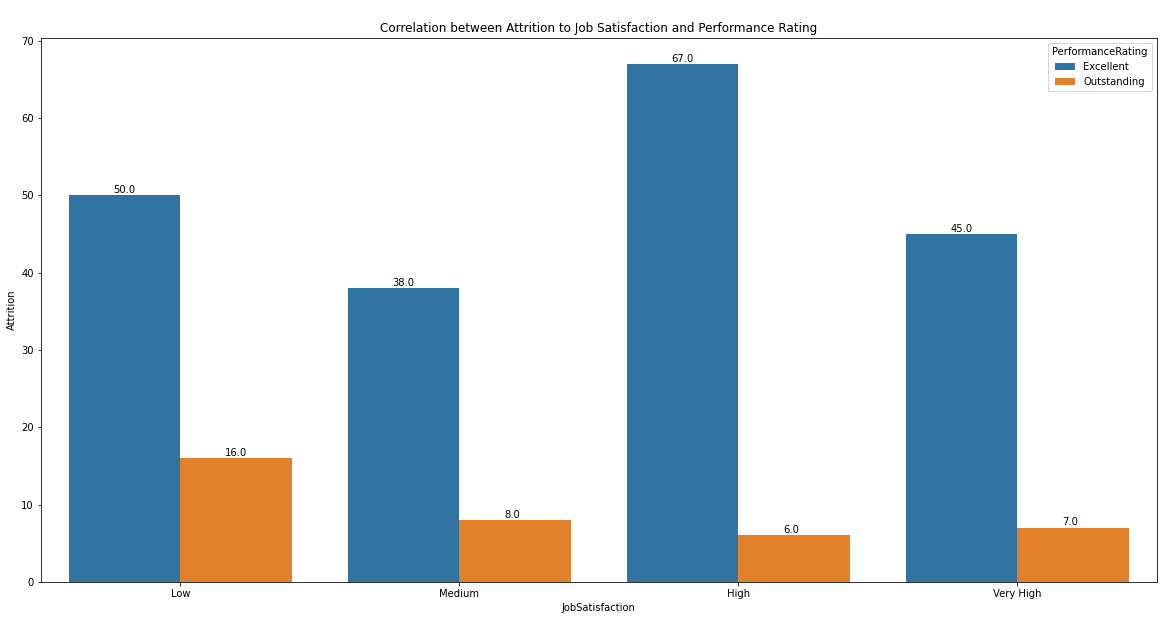

In [120]:
plt.figure(figsize = (20,10))
Graph5 = sns.countplot(x="JobSatisfaction", hue = "PerformanceRating", data=jobSatisfaction_performanceRate_attrition)

for p in Graph5.patches:
   Graph5.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.16, p.get_height()+0.30))

x_ticks_labels = ['Low', 'Medium', 'High', 'Very High']
Graph5.set_xticklabels(x_ticks_labels)

plt.legend(title='PerformanceRating', loc='upper right', labels=['Excellent','Outstanding'])

Graph5.set(title='\nCorrelation between Attrition to Job Satisfaction and Performance Rating')
plt.xlabel('JobSatisfaction')
plt.ylabel('Attrition')   
plt.show()

### **Data Science Question 6**

In [121]:
environmentSatisfaction_workLifeBalance = updated_attrition_Emp_df.select(col("EnvironmentSatisfaction"),("WorkLifeBalance"))

In [122]:
environmentSatisfaction_workLifeBalance = environmentSatisfaction_workLifeBalance.toPandas()

In [123]:
environmentSatisfaction_workLifeBalance

,EnvironmentSatisfaction,WorkLifeBalance
0,2,1
1,3,3
2,4,3
3,4,3
4,1,3
...,...,...
1465,3,3
1466,4,3
1467,2,3
1468,4,2


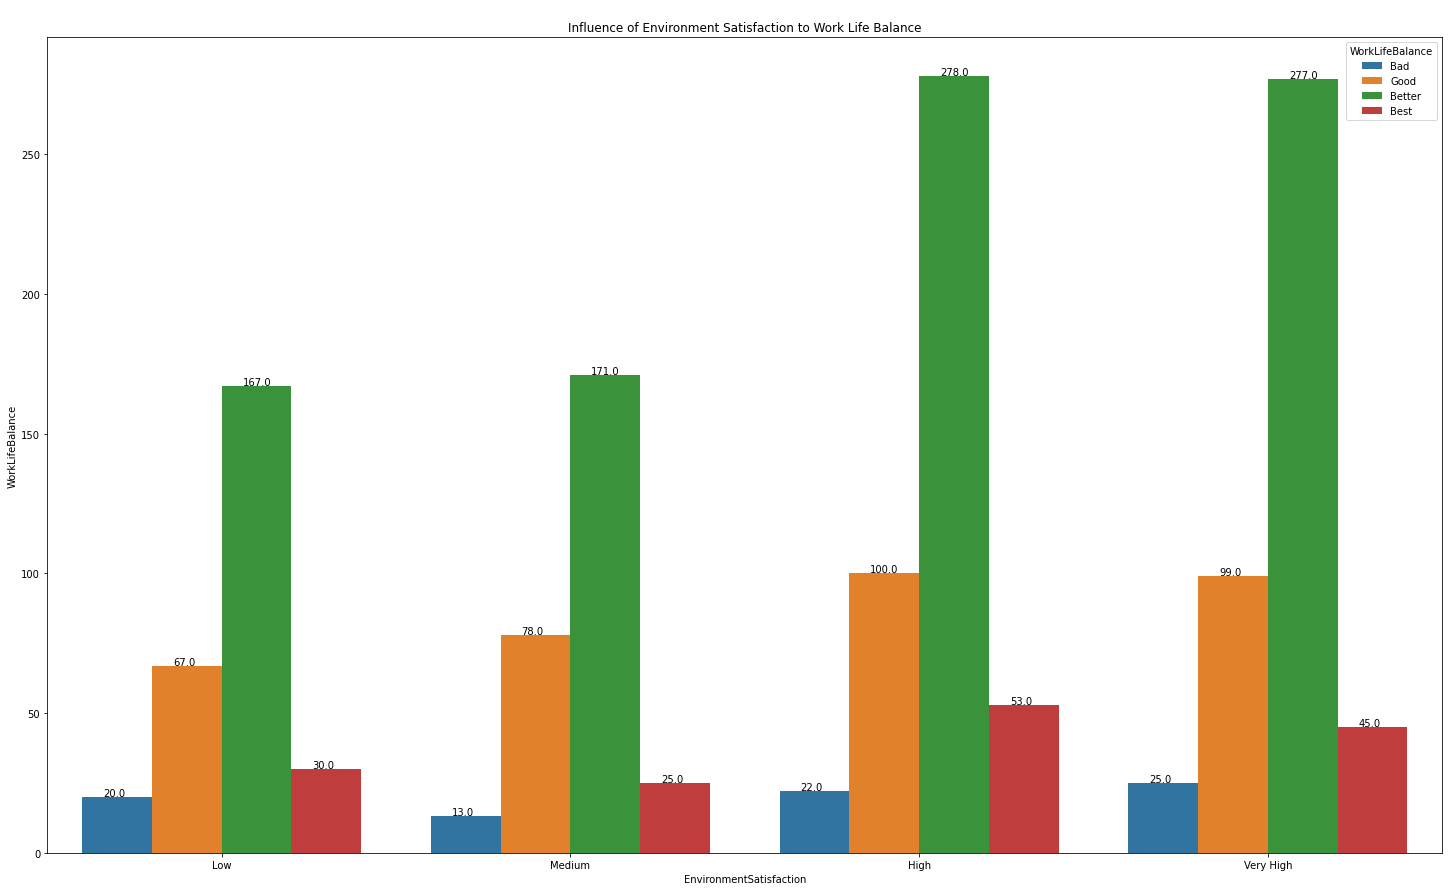

In [124]:
plt.figure(figsize = (25,15))
Graph6 = sns.countplot(x="EnvironmentSatisfaction", hue = "WorkLifeBalance", data=environmentSatisfaction_workLifeBalance)

for p in Graph6.patches:
  Graph6.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.06, p.get_height()+0.30))

x_ticks_labels = ['Low', 'Medium', 'High', 'Very High']
Graph6.set_xticklabels(x_ticks_labels)

plt.legend(title='WorkLifeBalance', loc='upper right', labels=['Bad','Good','Better','Best'])

Graph6.set(title='\nInfluence of Environment Satisfaction to Work Life Balance')
plt.xlabel('EnvironmentSatisfaction')
plt.ylabel('WorkLifeBalance') 
plt.show()

### **Data Science Question 7**

In [125]:
#find mean hourly rate
updated_attrition_Emp_df.select(mean("HourlyRate"))

avg(HourlyRate)
65.89115646258503


In [126]:
#find mean monthly income
updated_attrition_Emp_df.select(mean("MonthlyIncome"))

avg(MonthlyIncome)
6502.931292517007


In [127]:
DS7 = updated_attrition_Emp_df.select("JobRole","HourlyRate","MonthlyIncome","Attrition").where((updated_attrition_Emp_df.JobRole == "Sales Executive") 
& (updated_attrition_Emp_df.HourlyRate >= 65) & (updated_attrition_Emp_df.MonthlyIncome <= 6502)).show()

+---------------+----------+-------------+---------+
|        JobRole|HourlyRate|MonthlyIncome|Attrition|
+---------------+----------+-------------+---------+
|Sales Executive|        94|         5993|        1|
|Sales Executive|        72|         4568|        0|
|Sales Executive|        98|         5772|        0|
|Sales Executive|        75|         5454|        0|
|Sales Executive|        71|         5441|        0|
|Sales Executive|        87|         5010|        0|
|Sales Executive|        95|         6146|        0|
|Sales Executive|        76|         6172|        1|
|Sales Executive|        71|         4559|        1|
|Sales Executive|       100|         4465|        0|
|Sales Executive|        98|         6502|        0|
|Sales Executive|        99|         4907|        0|
|Sales Executive|        91|         5484|        0|
|Sales Executive|        65|         5228|        0|
|Sales Executive|        74|         4478|        0|
|Sales Executive|        73|         6349|    

In [128]:
df = attrition_Emp_df.toPandas()
fig = px.strip(df, x="HourlyRate", y="Attrition",  color="JobRole")
fig.show()

### **Data Science Question 8**

In [129]:
DS8 = updated_attrition_Emp_df.select("Age","TotalWorkingYears","StockOptionLevel","Attrition").where((updated_attrition_Emp_df.TotalWorkingYears >= 30) 
& (updated_attrition_Emp_df.StockOptionLevel == 3)).show()

+---+-----------------+----------------+---------+
|Age|TotalWorkingYears|StockOptionLevel|Attrition|
+---+-----------------+----------------+---------+
| 56|               36|               3|        0|
| 55|               34|               3|        0|
+---+-----------------+----------------+---------+



In [130]:
fig = go.Figure(data=[go.Bar(
    x=['35 Years Working', '36 Years Working'],
    y=[3, 3] )])
fig.update_layout(title_text='Senior Employees That Have High Stock Option And Stay In Company')

# **Split Training and Testing Dataset**

In [131]:
# Import relevant libraries
from sklearn.model_selection import train_test_split

In [132]:
updated_attrition_Emp_df_pd = updated_attrition_Emp_df.toPandas()
X = updated_attrition_Emp_df_pd[features]
y = updated_attrition_Emp_df_pd["Attrition"].values

In [133]:
#Split dataset to train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (1029, 13), X_test size: (441, 13)


# **Models & Algorithm**

## **Gradient Boosting Classifier Algorithm**

In [134]:
# Import all relevant libraries for Gradient Boosting
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [135]:
# Tuning for multiple learning rate to produce the best accuracy score for testing
learningRates_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in learningRates_list:
    gbc = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gbc.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(X_train, y_train)))
    print("Accuracy score (testing): {0:.3f}".format(gbc.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.839
Accuracy score (testing): 0.841
Learning rate:  0.075
Accuracy score (training): 0.844
Accuracy score (testing): 0.850
Learning rate:  0.1
Accuracy score (training): 0.848
Accuracy score (testing): 0.853
Learning rate:  0.25
Accuracy score (training): 0.873
Accuracy score (testing): 0.855
Learning rate:  0.5
Accuracy score (training): 0.880
Accuracy score (testing): 0.846
Learning rate:  0.75
Accuracy score (training): 0.893
Accuracy score (testing): 0.844
Learning rate:  1
Accuracy score (training): 0.887
Accuracy score (testing): 0.839


In [136]:
# Create new classifier based on the best learning rate discovered for testing which is 0.25
gbc2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
gbc2.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=2, max_features=2,
                           n_estimators=20, random_state=0)

In [137]:
# Prediction
gbc_prediction = gbc2.predict(X_test)

In [138]:
# Comparing actual and predicted value
gbc_result = pd.DataFrame({'Actual': y_test, 'Predicted': gbc_prediction})
print("Result: \n", gbc_result)

Result: 
      Actual  Predicted
0         0          0
1         0          0
2         1          0
3         0          0
4         1          1
..      ...        ...
436       0          0
437       0          0
438       0          0
439       0          0
440       0          0

[441 rows x 2 columns]


**Evaluate Model**

In [139]:
# Create a confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, gbc_prediction))

Confusion Matrix:
[[365   6]
 [ 58  12]]


In [140]:
# Create classification report after tuning the classifier
print("Classification Report")
print(classification_report(y_test, gbc_prediction))

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       371
           1       0.67      0.17      0.27        70

    accuracy                           0.85       441
   macro avg       0.76      0.58      0.60       441
weighted avg       0.83      0.85      0.82       441



In [141]:
gbc_testScore = gbc2.score(X_test, y_test)
gbc_testScore = gbc_testScore*100
print(f"GBC Test Score = {gbc_testScore:.2f} %")

GBC Test Score = 85.49 %


In [142]:
gbc_trainScore = gbc2.score(X_train, y_train)
gbc_trainScore = gbc_trainScore*100
print(f"GBC Train Score = {gbc_trainScore:.2f} %")

GBC Train Score = 87.27 %


## **Multiple Linear Regression**

In [143]:
# Import all relevant libraries
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [144]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [145]:
print("Intercept Value = ", model.intercept_)

Intercept Value =  0.8250804190781467


In [146]:
print("Coefficient Value \n", model.coef_)

Coefficient Value 
 [-4.02895462e-03  4.76140937e-03 -5.27482253e-06 -3.91796527e-02
 -1.20519913e-04 -5.97306380e-02 -3.01804433e-02 -6.68107737e-06
  2.15852044e-01 -2.02567604e-04 -5.14072454e-02 -2.09233750e-03
 -4.12438545e-02]


In [147]:
pd.DataFrame(model.coef_, X.columns, columns = ['Coeffecient Value'])

,Coeffecient Value
Age,-0.004029
Education,0.004761
EmployeeNumber,-0.000005
EnvironmentSatisfaction,-0.039180
HourlyRate,-0.000121
JobInvolvement,-0.059731
JobSatisfaction,-0.030180
MonthlyIncome,-0.000007
OverTime,0.215852
PerformanceRating,-0.000203


In [148]:
# Make predictions
y_pred_reg = model.predict(X_test)

In [149]:
# Comparing actual and predicted value
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_reg})
print("Result: \n", results)

Result: 
      Actual  Predicted
0         0   0.143135
1         0   0.192753
2         1   0.301368
3         0   0.056559
4         1   0.416377
..      ...        ...
436       0   0.130437
437       0   0.189804
438       0   0.169891
439       0   0.235259
440       0   0.035938

[441 rows x 2 columns]


**Evaluate model**

In [150]:
mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred_reg)
print("Mean Absolute Error = ", mean_absolute_error)

Mean Absolute Error =  0.24212900151078798


In [151]:
mean_squared_error = metrics.mean_squared_error(y_test, y_pred_reg)
print("Mean Squared Error = ", mean_squared_error)

Mean Squared Error =  0.11170406390734403


In [152]:
root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg))
print("Root Mean Squared Error = ", root_mean_squared_error)

Root Mean Squared Error =  0.33422157905698435


In [153]:
MLR_testScore = model.score(X_test, y_test)
MLR_testScore = MLR_testScore*100
print(f"MLR Test Score = {MLR_testScore:.2f} %")

MLR Test Score = 16.35 %


In [154]:
MLR_trainScore = model.score(X_train, y_train)
MLR_trainScore = MLR_trainScore*100
print(f"MLR Train Score = {MLR_trainScore:.2f} %")

MLR Train Score = 15.84 %
